In [1]:
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb, rgb2gray
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from skimage.segmentation import mark_boundaries
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import glob
import keras
from keras import layers
from keras.layers import Dense
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
import cv2
from cv2 import imread, createCLAHE
import glob
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from tqdm import tqdm
from keras.losses import Loss
from keras.callbacks import TensorBoard
from scipy.ndimage import distance_transform_edt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.applications import VGG19
from keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

2023-10-07 17:57:15.129340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 17:57:15.528056: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-07 17:57:17.544055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-07 17:57:17.544243: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/Original/*.png")
mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/Ground Truth/*.png")

In [3]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [4]:
def ground_truth_superpixel_1(img, ground_truth):
    # Perform superpixel segmentation
    num_segments = 400
    segments = slic(img, n_segments=num_segments, compactness=10)
    # segments = felzenszwalb(img, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(img, kernel_size=1, max_dist=2.5, ratio=0.5)

    # gradient = sobel(rgb2gray(img))
    # segments = watershed(gradient, markers=800, compactness=0.001)

    image_superpixel = label2rgb(segments, img, kind='avg')
    image_superpixel = rgb2gray(image_superpixel)
    num_superpixels = len(np.unique(segments))
    # print(f'The image contains {num_superpixels} superpixels.')

    image_boundaries = mark_boundaries(img, segments, color=(255, 0, 0))
    labels = segments.astype(np.int32)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))
    boundary_superpixels = set(np.unique(labels[boundary_mask]))

    # Exclude boundary superpixels
    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (labels == label)
        # Check if the superpixel intersects with the boundary
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = binary_erosion(boundary_mask,
                                            disk(
                                                3))  # erode the boundary mask to avoid including partial boundary pixels
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(labels[boundary_mask_]))

    num_segments_result = len(np.unique(valid_superpixels))
    # print(f'The result image contains {num_segments_result} superpixels.')

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (labels == label)
        if label in inside_superpixels:
            color = (255, 255, 255)  # yellow for inside superpixels
            inside_labels.append(label)
        else:
            color = (0, 0, 0)  # blue for outside superpixels
            outside_labels.append(label)
        result[mask] = color

    # Set background class for the omitted superpixels
    background_mask = (ground_truth == 0)
    result[background_mask] = (0, 0, 0)

    # # Show number of labels in the result image
    # print(
    #     f"The result image contains {len(inside_labels)} inside superpixels and {len(outside_labels)} outside superpixels.")

    # Visualize the result
    # cv2.imshow('Image', img)
    # cv2.imshow('Ground Truth', ground_truth)
    # cv2.imshow('Superpixels',
    #            cv2.cvtColor(cv2.normalize(labels, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U), cv2.COLOR_GRAY2BGR))
    # cv2.imshow('Result', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    #
    # fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    # ax[0].imshow(image_superpixel)
    # ax[0].set_title('Superpixel image')
    # ax[1].imshow(ground_truth, cmap='gray')
    # ax[1].set_title('Binary ground truth')
    # ax[2].imshow(image_boundaries)
    # ax[2].set_title('Mark boundaries')
    # ax[3].imshow(result)
    # ax[3].set_title('Ground truth result')
    # plt.show()
    return result

In [5]:
def ground_truth_superpixel_3(img, ground_truth):
    # Perform SLIC superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)
    # segments = felzenszwalb(img, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(img, kernel_size=1, max_dist=2.5, ratio=0.5)

    # Find superpixels intersecting with the image boundaries
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0
    boundary_superpixels = set(segments[boundary_mask])

    # Show the number of superpixels with intersection with image boundaries
    num_boundary_superpixels = len(boundary_superpixels)
    # print(f'The number of superpixels with intersection with image boundaries: {num_boundary_superpixels}')

    # Overlay superpixels with ground truth
    labels = segments.astype(np.int32)

    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    for label in outside_superpixels:
        mask = (labels == label)
        result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels outside the boundary

    for label in inside_superpixels:
        mask = (labels == label)
        result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels inside the boundary

    for label in boundary_superpixels:
        mask = (labels == label)
        num_pixels_inside = np.sum(mask & inside_mask)
        num_pixels_outside = np.sum(mask & outside_mask)

        if num_pixels_outside > num_pixels_inside:
            result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with more pixels outside the boundary
        elif num_pixels_outside < num_pixels_inside:
            result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with more pixels inside the boundary
        else:
            d1 = cv2.distanceTransform((mask & outside_mask).astype(np.uint8), cv2.DIST_L2, 5)
            d2 = cv2.distanceTransform((mask & inside_mask).astype(np.uint8), cv2.DIST_L2, 5)

            d1_sorted = np.sort(d1[mask & boundary_mask])
            d2_sorted = np.sort(d2[mask & boundary_mask])

            threshold_idx = len(d1_sorted) // 2
            if np.sum(d1_sorted[:threshold_idx]) > np.sum(d1_sorted[threshold_idx:]):
                result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with larger distance to outside
            else:
                result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with larger distance to inside

    # cv2.imshow('Result', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return result

In [6]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

In [7]:
def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

In [8]:
def sensitivity(gt_mask, pred_mask):
    """
    Computes sensitivity (recall) of the predicted segmentation mask
    given the ground truth mask.

    Args:
        gt_mask (np.array): binary ground truth segmentation mask.
        pred_mask (np.array): binary predicted segmentation mask.

    Returns:
        float: sensitivity score.
    """
    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [10]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred,1)

In [1]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (256, 256))

                filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                                        "newgt/newgt_superpixel_CVC_slic800", os.path.basename(mask_path))
                if not os.path.exists(filename):

                    mask = cv2.imread(mask_path,0)
                    mask = cv2.resize(mask, (256, 256))

                    result = ground_truth_superpixel_1(img, mask)
                    # result = ground_truth_superpixel_3(img, mask)

                    result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(result)
                    # plt.title("hggh")

                    # soft_label = binary_to_soft_label(result, threshold_value=threshold_value)
                    # cv2.imshow("kjkj",soft_label)
                    # cv2.waitKey(0)
                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                    cv2.imwrite(filename, result)

                else:
                    result = cv2.imread(filename, 0)
                # print(result.type)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # soft_label = binary_to_soft_label(result)

                # normalize the image and mask to have values between 0 and 1
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                result= result/ 255.0
                # result = result / 255.0
                # print(soft_label.shape)
                # cv2.imshow("dfg", soft_label)
                # cv2.waitKey(0)
                # Append the preprocessed data to the respective lists

                batch_images.append(img)
                batch_masks.append(result)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Visualize the images and masks in the batch
            # for j in range(batch_images.shape[0]):
            #     plt.subplot(1, 2, 1)
            #     plt.imshow(batch_images[j])
            #     plt.title("Image")
            #
            #     plt.subplot(1, 2, 2)
            #     plt.imshow(batch_masks[j])
            #     plt.title("Mask")
            #
            #     plt.show()

            yield batch_images, batch_masks
# #
# generator = data_generator(image_paths, mask_paths, 1)
# 
# for _,imgpath in tqdm(enumerate(image_paths)):
#    batch = next(generator)


In [12]:
assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.1, random_state=2023
)

# Define the batch size
batch_size = 8

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# batch_size = 5  # Number of batches to visualize

# for _ in range(batch_size):
#     batch = next(train_generator)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)


65
7


In [13]:
def build_unet(input_size=(256,256,3)):

    inputs  = Input(input_size)

    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool5)
    conv6 = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)


    up7 = layers.concatenate([Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv6), conv5], axis=3)


    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)


    up8 = layers.concatenate([Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv7), conv4], axis=3)

    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv8), conv3], axis=3)

    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = layers.concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv9), conv2], axis=3)

    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = layers.concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv10), conv1], axis=3)

    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(1, (1,1), activation='relu')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])


In [14]:
def build_smaller_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='relu')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [15]:
!rm -rf '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [16]:
%load_ext tensorboard
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [17]:
weight_path="{}_Unet_superpixel_cvc_slic800.best.hdf5".format('cxr_reg')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2023-10-07 17:59:15.487141: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-10-07 17:59:15.487232: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-10-07 17:59:15.593812: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-10-07 17:59:15.594603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-07 17:59:15.669078: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-10-07 17:59:15.669534: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [18]:
model =build_unet(input_size=(256,256,3))
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss= dice_coef_loss,metrics= [dice_coef, precision, iou, sensitivity] ,run_eagerly=True)
model.summary()

2023-10-07 17:59:28.392212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-07 17:59:28.524032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-07 17:59:28.524604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-07 17:59:28.527580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [19]:
loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

# model.save("double_unet_super_pixel_Skin_slic800.h5")
model.save("unet_super_pixel_cvc_slic800.h5")

/tmp/ipykernel_8213/4239034627.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(


Number of images: 522
Number of masks: 522
Epoch 1/50


2023-10-07 17:59:53.812150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2023-10-07 17:59:55.747344: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-07 17:59:55.750926: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-07 17:59:55.750969: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-10-07 17:59:55.751124: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

2023-10-07 18:00:03.826660: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-07 18:00:04.869805: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-07 18:00:05.901315: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

 1/65 [..............................] - ETA: 30:26 - loss: 0.9405 - dice_coef: 0.0595 - precision: 0.0000e+00 - iou: 0.0307 - sensitivity: 0.0372

2023-10-07 18:00:17.986373: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-10-07 18:00:17.986454: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 2/65 [..............................] - ETA: 1:59 - loss: 0.9253 - dice_coef: 0.0747 - precision: 0.0000e+00 - iou: 0.0389 - sensitivity: 0.0492 

2023-10-07 18:00:19.731473: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-10-07 18:00:19.755380: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-10-07 18:00:19.841777: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 1072 callback api events and 1079 activity events. 
2023-10-07 18:00:19.862725: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-10-07 18:00:19.865967: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2023_10_07_18_00_19/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


65/65 [==============================] - ETA: 0s - loss: 0.8064 - dice_coef: 0.1936 - precision: 0.0922 - iou: 0.1103 - sensitivity: 7.6408Number of images: 58
Number of masks: 58

Epoch 1: val_loss improved from inf to 0.79179, saving model to cxr_reg_Unet_superpixel_cvc_slic800.best.hdf5
65/65 [==============================] - 74s 705ms/step - loss: 0.8064 - dice_coef: 0.1936 - precision: 0.0922 - iou: 0.1103 - sensitivity: 7.6408 - val_loss: 0.7918 - val_dice_coef: 0.2082 - val_precision: 0.0655 - val_iou: 0.1178 - val_sensitivity: 49.3876 - lr: 1.0000e-04
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.7365 - dice_coef: 0.2639 - precision: 0.1264 - iou: 0.1562 - sensitivity: 8.4638
Epoch 2: val_loss improved from 0.79179 to 0.73253, saving model to cxr_reg_Unet_superpixel_cvc_slic800.best.hdf5
65/65 [==============================] - 40s 559ms/step - loss: 0.7365 - dice_coef: 0.2639 - precision: 0.1264 - iou: 0.1562 - sensitivity: 8.4638 - val_loss: 0.7325 - 

In [20]:
test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/test/original/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/test/ground_truth/*.png")

(32, 256, 256, 3)
(32, 256, 256)


/home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 3s 66ms/step
(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256)
Dices: [<tf.Tensor: shape=(), dtype=float64, numpy=0.3986092764542203>, <tf.Tensor: shape=(), dtype=float64, numpy=0.39426733864650726>, <tf.Tensor: shape=(), dtype=float64, numpy=0.00013268472184859475>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0006134246173312901>, <tf.Tensor: shape=(), dtype=float64, numpy=0.001562461704369991>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0002671208769106999>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0008569354643582057>, <tf.Tensor: shape=(), dtype=float64, numpy=0.00023694106300123485>, <tf.Tensor: shape=(), dtype=float64, numpy=0.779161222521393>, <tf.Tensor: shape=(), dtype=float64, numpy=0.1875673218503256>, <tf.Tensor: shape=(), dtype=float64, numpy=0.6681984601035859>, <tf.Tensor: shape=(), dtype=float64, numpy=0.00028654132262979757>, <tf.Tensor: shape=(), dtype=float64, numpy=0.4983363974497729>, <tf.Tensor: shape=(), dtype=floa

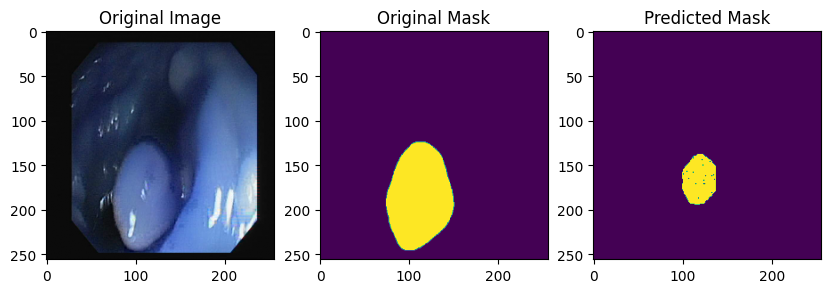

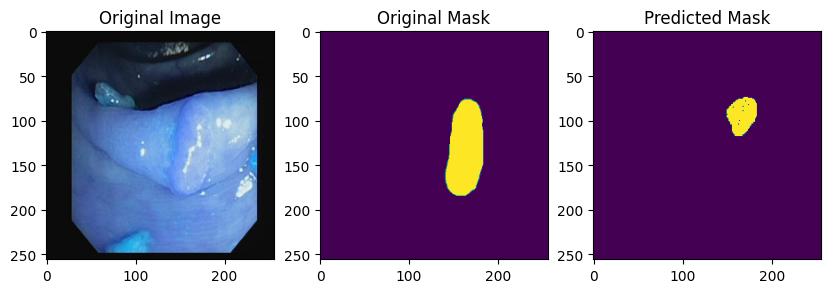

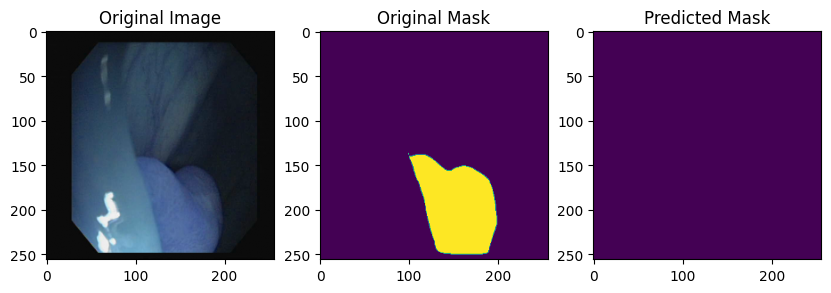

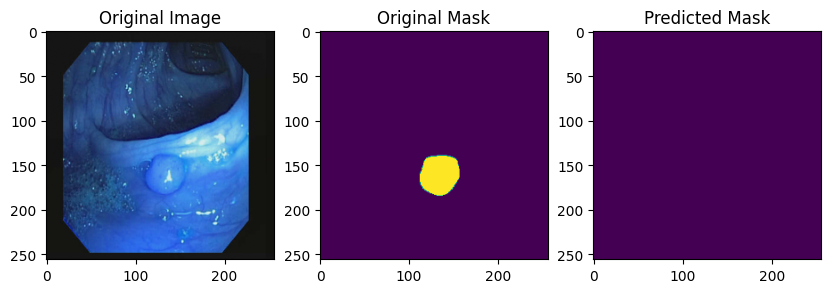

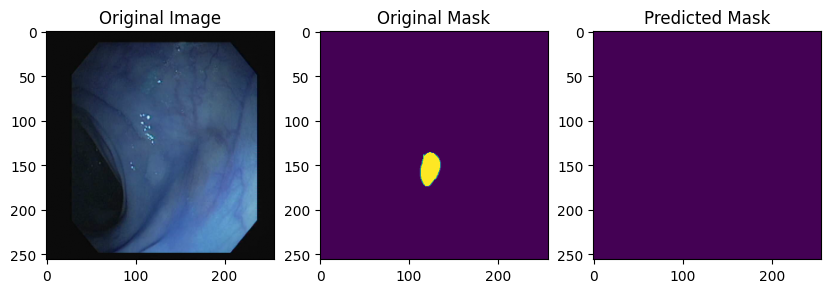

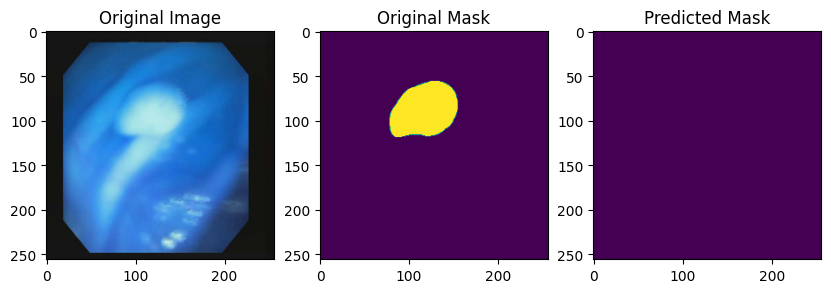

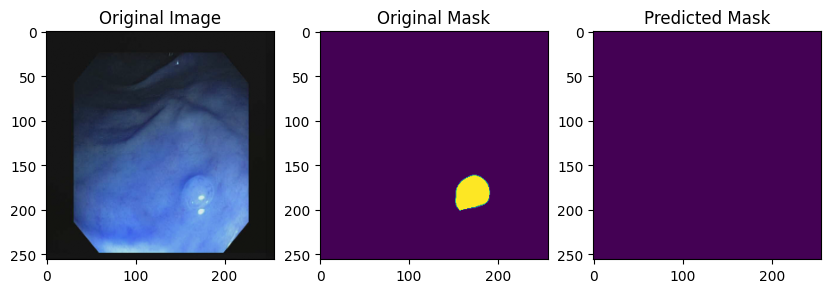

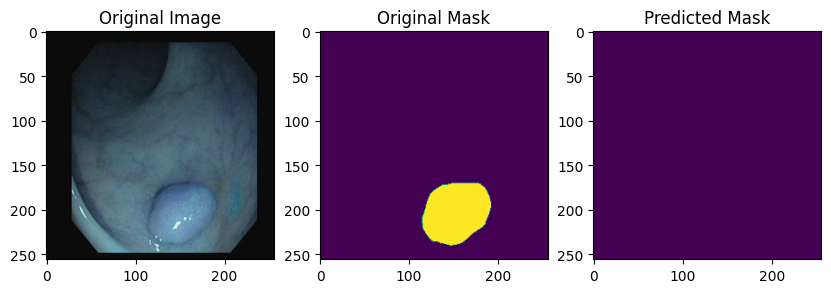

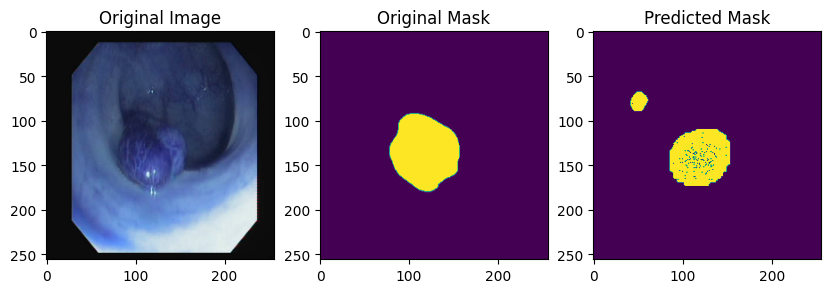

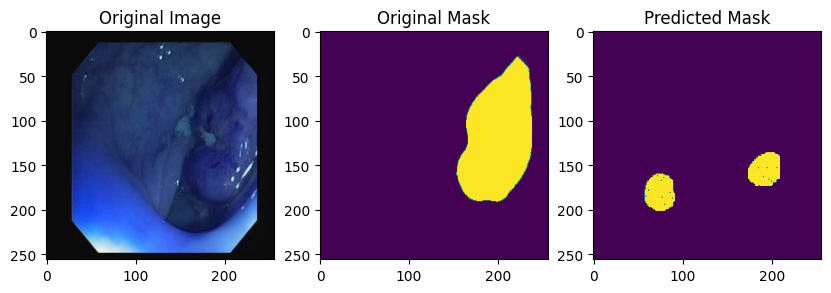

In [21]:
dice_scores = []
test_images = []
ground_truth_test_images = []
for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (256, 256))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (256, 256))

# normalize the image and mask to have values between 0 and 1

    test_image = test_image / 255.0
    ground_truth_test_image= ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)


#by the end of this line, I have superpixeled images.
# convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)
print(test_images.shape)
print(ground_truth_test_images.shape)
# add a channel dimension to the masks
# ground_truth_test_images = np.expand_dims(ground_truth_test_images, axis=-1)

model.load_weights("{}_Unet_superpixel_cvc_slic800.best.hdf5".format('cxr_reg'))

# Make predictions
# predicted_masks = model.predict(test_images)
tf.config.run_functions_eagerly(True)
predicted_masks = model.predict(
    test_images,
    batch_size=1,
    verbose=1,
    steps=None,
    callbacks=None
)

predicted_mask_array = np.array(predicted_masks)
print(predicted_mask_array.shape)

# Convert the NumPy array to uint8 format
predicted_mask_array = (predicted_mask_array * 255).astype(np.uint8)
print(predicted_mask_array.shape)


dst = np.empty([predicted_mask_array.shape[0],predicted_mask_array.shape[1],predicted_mask_array.shape[2]])
kernel = np.ones((5,5),np.float64)/25
# dst = predicted_mask_array

#
for i in range(predicted_mask_array.shape[0]):

        threshold_value = 1
        _, dst[i] = cv2.threshold(predicted_mask_array[i], threshold_value, 255, cv2.THRESH_BINARY)
        dst[i] = np.array(dst[i])
        dst[i] = tf.convert_to_tensor(dst[i] / 255.0,dtype=predicted_masks.dtype)

print(dst.shape)

## Cast the input tensor to a double tensor
ground_truth_test_images = tf.cast(ground_truth_test_images, dtype=tf.float64)
predicted_masks = tf.cast(dst, dtype=tf.float64)
# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    dice = dice_coef(y_true, y_pred)

    y_pred = predicted_masks[i]

    precision_value = precision(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

# dice_score = dice_coef(ground_truth_test_images, dst)
# precision_val = precision(ground_truth_test_images, dst)
# sensitivity_val = sensitivity(ground_truth_test_images, dst)
# iou_val = iou(ground_truth_test_images, dst)
# print(type(dst))

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)

n =10 # number of images to show
for i in range(n):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i])
    ax[1].set_title('Original Mask')
    ax[2].imshow(dst[i])
    ax[2].set_title('Predicted Mask')
    plt.show()